## Dependencies

In [1]:
import warnings, json, re, math
from melanoma_utility_scripts import *
from kaggle_datasets import KaggleDatasets
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV
from xgboost import XGBClassifier

SEED = 42
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Model parameters

In [2]:
config = {
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "DATASET_PATH": 'melanoma-256x256'
}

with open('config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'N_FOLDS': 5, 'N_USED_FOLDS': 5, 'DATASET_PATH': 'melanoma-256x256'}

# Load data

In [3]:
database_base_path = '/kaggle/input/siim-isic-melanoma-classification/'
train = pd.read_csv(f"/kaggle/input/{config['DATASET_PATH']}/train.csv")
train_ext = pd.read_csv(f"/kaggle/input/isic2019-256x256/train.csv")
train_malig_1 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_1.csv")
train_malig_3 = pd.read_csv(f"/kaggle/input/malignant-v2-256x256/train_malig_3.csv")
train['external'] = 0
train_ext['external'] = 1
train_malig_1['external'] = 0
train_malig_3['external'] = 0
train = pd.concat([train, train_ext, train_malig_1, train_malig_3])

test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(train))
display(train.head())
print(f'Test samples: {len(test)}')
display(test.head())

Train samples: 61853


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,external
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0.0,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1.0,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2.0,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3.0,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4.0,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [4]:
display(train.describe())

,age_approx,target,tfrecord,width,height,patient_code,external
count,61275.000000,61853.000000,61853.000000,61853.000000,61853.000000,33710.000000,61853.000000
mean,51.555528,0.137455,11.685432,2579.533151,1798.705689,739.146544,0.409536
std,16.376824,0.344330,10.434983,2218.072246,1434.438340,530.738720,0.491752
min,0.000000,0.000000,-1.000000,576.000000,450.000000,0.000000,0.000000
25%,40.000000,0.000000,4.000000,824.000000,640.000000,275.000000,0.000000
50%,50.000000,0.000000,9.000000,1024.000000,1024.000000,663.000000,0.000000
75%,65.000000,0.000000,14.000000,5184.000000,3456.000000,1115.000000,1.000000
max,90.000000,1.000000,59.000000,6000.000000,6000.000000,2055.000000,1.000000


# Missing values

In [5]:
# age_approx (mean)
train['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
test['age_approx'].fillna(train['age_approx'].mode()[0], inplace=True)
# anatom_site_general_challenge (NaN)
# train['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# test['anatom_site_general_challenge'].fillna('NaN', inplace=True)
# sex (mode)
train['sex'].fillna(train['sex'].mode()[0], inplace=True)
test['sex'].fillna(train['sex'].mode()[0], inplace=True)

# Feature engineering

In [6]:
target_mean = train['target'].mean()
bias = 15
sex_age_mean_2 = train.groupby(['sex', 'age_approx'])['target'].agg(['mean', 'count']).reset_index()
sex_age_mean_2['sex_age_mean_2'] = ((sex_age_mean_2['mean']*sex_age_mean_2['count'])+(target_mean*bias))/(sex_age_mean_2['count']+bias)
train = train.merge(sex_age_mean_2[['sex', 'age_approx', 'sex_age_mean_2']], on=['sex','age_approx'], how='left')
test = test.merge(sex_age_mean_2[['sex', 'age_approx', 'sex_age_mean_2']], on=['sex','age_approx'], how='left')

train['sex_age_mean_2'].fillna(target_mean, inplace=True)
test['sex_age_mean_2'].fillna(target_mean, inplace=True)

print('Train set')
display(train.head())
print('Test set')
display(test.head())

Train set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height,patient_code,external,sex_age_mean_2
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0,0,6000,4000,0.0,0,0.093734
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0,0,6000,4000,1.0,0,0.099011
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0,6,1872,1053,2.0,0,0.118810
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0,0,1872,1053,3.0,0,0.099011
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0,11,6000,4000,4.0,0,0.111720


Test set


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,sex_age_mean_2
0,ISIC_0052060,IP_3579794,male,70.0,NaN,0.233191
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity,0.065403
2,ISIC_0058510,IP_7960270,female,55.0,torso,0.111720
3,ISIC_0073313,IP_6375035,female,50.0,torso,0.118810
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity,0.099011


# Training

In [7]:
skf = KFold(n_splits=config['N_USED_FOLDS'], shuffle=True, random_state=SEED)
test['target'] = 0

for fold,(idxT, idxV) in enumerate(skf.split(np.arange(15))):
    print(f'\nFOLD: {fold+1}')
    print(f'TRAIN: {idxT} VALID: {idxV}')
    
    train[f'fold_{fold+1}'] = train.apply(lambda x: 'train' if x['tfrecord'] in idxT else 'validation', axis=1)
    x_train = train[train['tfrecord'].isin(idxT)]
    y_train = x_train['target']
    x_valid = train[~train['tfrecord'].isin(idxT)]
    y_valid = x_valid['target']

    # Evaludation
    preds = train['sex_age_mean_2']
    train[f'pred_fold_{fold+1}'] = preds
    
    # Inference
    preds = test['sex_age_mean_2']
    test[f'pred_fold_{fold+1}'] = preds
    test['target'] += preds / config['N_USED_FOLDS']


FOLD: 1
TRAIN: [ 1  2  3  4  5  6  7  8 10 12 13 14] VALID: [ 0  9 11]

FOLD: 2
TRAIN: [ 0  1  2  3  4  6  7  9 10 11 12 14] VALID: [ 5  8 13]

FOLD: 3
TRAIN: [ 0  3  4  5  6  7  8  9 10 11 12 13] VALID: [ 1  2 14]

FOLD: 4
TRAIN: [ 0  1  2  3  5  6  8  9 11 12 13 14] VALID: [ 4  7 10]

FOLD: 5
TRAIN: [ 0  1  2  4  5  7  8  9 10 11 13 14] VALID: [ 3  6 12]


# Model evaluation

In [8]:
def func(x):
    if x['fold_1'] == 'validation':
        return x['pred_fold_1']
    elif x['fold_2'] == 'validation':
        return x['pred_fold_2']
    elif x['fold_3'] == 'validation':
        return x['pred_fold_3']
    elif x['fold_4'] == 'validation':
        return x['pred_fold_4']
    elif x['fold_5'] == 'validation':
        return x['pred_fold_5']
    
train['pred'] = train.apply(lambda x: func(x), axis=1)

auc_oof = roc_auc_score(train['target'], train['pred'])
print(f'Overall OOF AUC = {auc_oof:.3f}')

df_oof = train[['image_name', 'target', 'pred']]
df_oof.to_csv('oof.csv', index=False)
display(df_oof.head())
display(df_oof.describe().T)

Overall OOF AUC = 0.676


,image_name,target,pred
0,ISIC_2637011,0,0.093734
1,ISIC_0015719,0,0.099011
2,ISIC_0052212,0,0.118810
3,ISIC_0068279,0,0.099011
4,ISIC_0074268,0,0.111720


,count,mean,std,min,25%,50%,75%,max
target,61853.0,0.137455,0.344330,0.000000,0.000000,0.00000,0.00000,1.000000
pred,61853.0,0.137430,0.076681,0.014933,0.086851,0.11881,0.15623,0.420042


# Model evaluation

In [9]:
display(evaluate_model(train, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(train, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.683741,0.654384,0.029356,0.682947,0.652809,0.680936,0.657757,0.680936,0.652646,0.688087,0.653726,0.685797,0.654984
Accuracy,0.926349,0.769159,0.157190,0.927680,0.767081,0.927684,0.767063,0.925465,0.770611,0.925458,0.770393,0.925457,0.770648
Precision,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Recall,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
F1-score,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Support,2706.400000,5795.600000,-3089.200000,2659.000000,5843.000000,2659.000000,5843.000000,2737.000000,5765.000000,2740.000000,5762.000000,2737.000000,5765.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.683741,0.654384,0.029356,0.682947,0.652809,0.680936,0.657757,0.680936,0.652646,0.688087,0.653726,0.685797,0.654984
male,0.679249,0.655726,0.023523,0.680818,0.652280,0.666072,0.669898,0.682361,0.642604,0.681475,0.656918,0.685519,0.656931
female,0.671594,0.633678,0.037916,0.659584,0.642191,0.683369,0.624041,0.666655,0.635944,0.682215,0.626821,0.666148,0.639395
head/neck,0.661536,0.590167,0.071369,0.672887,0.582747,0.659554,0.591776,0.654210,0.594042,0.657890,0.591117,0.663137,0.591154
upper extremity,0.684685,0.639526,0.045158,0.684364,0.636930,0.675276,0.645535,0.689252,0.629056,0.686976,0.639914,0.687555,0.646196
lower extremity,0.631661,0.633250,-0.001588,0.627849,0.633165,0.628208,0.639465,0.632128,0.625081,0.642193,0.628949,0.627929,0.639588
torso,0.681573,0.677702,0.003871,0.672258,0.717072,0.670683,0.713794,0.680281,0.686527,0.703591,0.593757,0.681053,0.677360
0 <= age < 26,0.582950,0.588451,-0.005501,0.555899,0.611379,0.613758,0.552734,0.588379,0.589086,0.573119,0.590281,0.583595,0.598777
26 <= age < 40,0.554783,0.543075,0.011708,0.547419,0.555137,0.551499,0.556298,0.561609,0.524578,0.566114,0.531846,0.547273,0.547517


# Visualize predictions

In [10]:
train['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    train['pred'] += train[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(train[train['target'] > .5])}")
print(f"Train positive predictions: {len(train[train['pred'] > .5])}")
print(f"Train positive correct predictions: {len(train[(train['target'] > .5) & (train['pred'] > .5)])}")
    
print('Top 10 samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))

print('Top 10 predicted positive samples')
display(train[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in train.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 8502
Train positive predictions: 0
Train positive correct predictions: 0
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.093734,0.093734,0.093734,0.093734,0.093734,0.093734
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.099011,0.099011,0.099011,0.099011,0.099011,0.099011
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.118810,0.118810,0.118810,0.118810,0.118810,0.118810
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.099011,0.099011,0.099011,0.099011,0.099011,0.099011
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.111720,0.111720,0.111720,0.111720,0.111720,0.111720
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.086851,0.086851,0.086851,0.086851,0.086851,0.086851
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.049840,0.049840,0.049840,0.049840,0.049840,0.049840
7,ISIC_0075663,female,35.0,torso,unknown,0,0.086544,0.086544,0.086544,0.086544,0.086544,0.086544
8,ISIC_0075914,male,30.0,torso,unknown,0,0.060952,0.060952,0.060952,0.060952,0.060952,0.060952
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.118810,0.118810,0.118810,0.118810,0.118810,0.118810


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.111720,0.111720,0.111720,0.111720,0.111720,0.111720
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.118810,0.118810,0.118810,0.118810,0.118810,0.118810
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.142243,0.142243,0.142243,0.142243,0.142243,0.142243
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.213383,0.213383,0.213383,0.213383,0.213383,0.213383
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.153519,0.153519,0.153519,0.153519,0.153519,0.153519
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.239161,0.239161,0.239161,0.239161,0.239161,0.239161
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.086544,0.086544,0.086544,0.086544,0.086544,0.086544
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.285054,0.285054,0.285054,0.285054,0.285054,0.285054
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.213383,0.213383,0.213383,0.213383,0.213383,0.213383
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.060952,0.060952,0.060952,0.060952,0.060952,0.060952


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Visualize test predictions

In [11]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

Test predictions 0|10982
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_0052060,male,70.0,NaN,0.233191,0.233191,0.233191,0.233191,0.233191,0.233191
1,ISIC_0052349,male,40.0,lower extremity,0.065403,0.065403,0.065403,0.065403,0.065403,0.065403
2,ISIC_0058510,female,55.0,torso,0.111720,0.111720,0.111720,0.111720,0.111720,0.111720
3,ISIC_0073313,female,50.0,torso,0.118810,0.118810,0.118810,0.118810,0.118810,0.118810
4,ISIC_0073502,female,45.0,lower extremity,0.099011,0.099011,0.099011,0.099011,0.099011,0.099011
5,ISIC_0074618,male,50.0,lower extremity,0.126891,0.126891,0.126891,0.126891,0.126891,0.126891
6,ISIC_0076801,male,45.0,upper extremity,0.093734,0.093734,0.093734,0.093734,0.093734,0.093734
7,ISIC_0077586,male,50.0,lower extremity,0.126891,0.126891,0.126891,0.126891,0.126891,0.126891
8,ISIC_0082004,female,45.0,torso,0.099011,0.099011,0.099011,0.099011,0.099011,0.099011
9,ISIC_0082785,male,65.0,lower extremity,0.213383,0.213383,0.213383,0.213383,0.213383,0.213383


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5


# Test set predictions

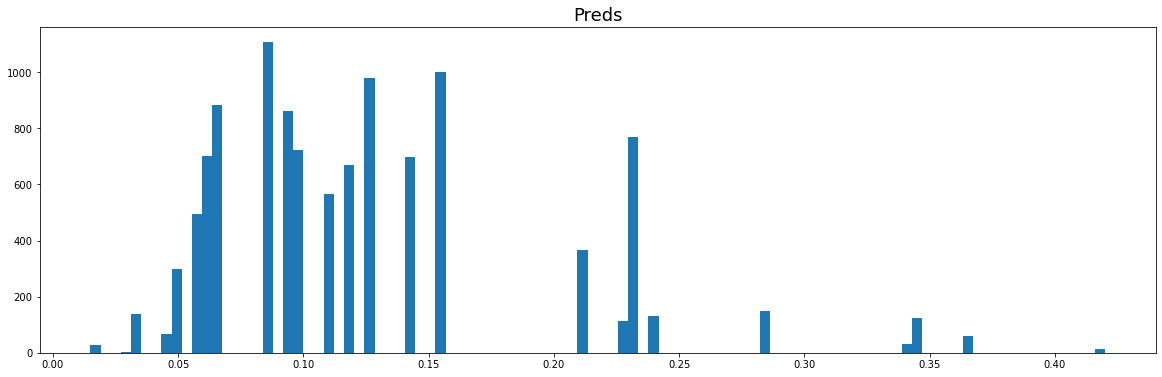

,image_name,target
0,ISIC_0052060,0.233191
1,ISIC_0052349,0.065403
2,ISIC_0058510,0.111720
3,ISIC_0073313,0.118810
4,ISIC_0073502,0.099011
5,ISIC_0074618,0.126891
6,ISIC_0076801,0.093734
7,ISIC_0077586,0.126891
8,ISIC_0082004,0.099011
9,ISIC_0082785,0.213383


,target
count,10982.000000
mean,0.123739
std,0.065334
min,0.014933
25%,0.086544
50%,0.111720
75%,0.153519
max,0.420042


In [12]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']

fig = plt.subplots(figsize=(20, 6))
plt.hist(submission['target'], bins=100)
plt.title('Preds', size=18)
plt.show()

display(submission.head(10))
display(submission.describe())

submission[['image_name', 'target']].to_csv('submission.csv', index=False)